# Using Naive Bayes to Predict What State You're From (If You Live in India)

In [23]:
%matplotlib inline
from math import prod
import numpy as np
import pandas as pd
import requests
import ipywidgets as wg
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

base_url = 'http://digital-library.census.ihsn.org/index.php/api/tables/'
idx = pd.IndexSlice

## Using the India Census API

I have some preemptive metadata in a csv file. The India Census API uses codes for many of the different fields, some of which is provided alongside code labels with each request, but others are common and inferred through this metadata.

In [24]:
# Create maps for state, district, 
# subdistrict, and town-village
# 0 means ALL
sdsdtv = pd.read_csv('data/PC11_TV_DIR.csv')

# States map
states = sdsdtv.loc[ (sdsdtv['District Code'] == 0) \
                    & (sdsdtv['Sub District Code'] == 0) \
                    & (sdsdtv['Town-Village Code'] == 0) ]
states = states[[
    'State Code', 
    'Town-Village Name'
]]
states = states.set_index('State Code')
states = states['Town-Village Name']
states.at[0] = 'ALL'
states = states.sort_index()
states = states.rename('State Name')

# Districts map
districts = sdsdtv.loc[ (sdsdtv['Sub District Code'] == 0) \
                    & (sdsdtv['Town-Village Code'] == 0) ]
districts = districts[[ 'District Code', 'Town-Village Name' ]]
districts = districts.drop_duplicates(subset=['District Code'])
districts = districts.set_index('District Code')
districts = districts['Town-Village Name']
districts.at[0] = 'All'
districts = districts.sort_index()
districts = districts.rename('District Name')

# Sub Districts map
sub_districts = sdsdtv.loc[ (sdsdtv['Town-Village Code'] == 0) ]
sub_districts = sub_districts[[
    'Sub District Code',
    'Town-Village Name'
]]
sub_districts = sub_districts.drop_duplicates(subset=['Sub District Code'])
sub_districts = sub_districts.set_index('Sub District Code')
sub_districts = sub_districts['Town-Village Name']
sub_districts.at[0] = 'All'
sub_districts = sub_districts.sort_index()
sub_districts = sub_districts.rename('Sub District Name')

# Town/Villages map
town_villages = sdsdtv[[ 'Town-Village Code', 'Town-Village Name' ]]
town_villages = town_villages.drop_duplicates(subset=['Town-Village Code'])
town_villages = town_villages.set_index('Town-Village Code')
town_villages = town_villages['Town-Village Name']
town_villages.at[0] = 'All'
town_villages = town_villages.sort_index()
town_villages = town_villages.rename('Sub District Name')

I created a simple interface to help me pull relevant data from the API. That way I'm not pulling and saving a large dataset to do work with

In [25]:
def get_dataset(table, **kwargs):
    """
    Call the India Census API with args
    to retrieve filtered data
    
    :param table:    Census API table to query
    :param **kwargs: Query parameters to send to API
    
    :returns: data retrieved from API as pandas DataFrame
    """
    # Common features in all tables
    common_features = {
        'state': states,
        'district': districts,
        'subdistrict': sub_districts,
        'town': town_villages
    }
    
    # Get info specific to dataset (features)
    year = kwargs.pop('year', '2011')
    info_url = base_url + f'/info/{year}/{table}'
    info = requests.get(info_url).json()
    features = info['result']['result_']['features']
    feature_map = { 
        feature['feature_name'] : pd.Series(
            data=[c['label'] for c in feature['code_list']],
            index=[c['code'] for c in feature['code_list']])
        for feature in features }
    feature_map |= common_features
    
    # Get data
    data_url = base_url + f'/data/{year}/{table}'
    query_string = '?' + '&'.join(f'{k}={v}' for k,v in kwargs.items()) if kwargs else ''
    body = requests.get(data_url+query_string).json()
    
    # Map codes to features in dataset
    df = pd.DataFrame(body['data'])
    for feature, labels in feature_map.items():
        if feature in df:
            df[feature] = df[feature].map(lambda r: labels.at[r])
        
    # Return dataframe
    return df

## Getting Prior Probabilities

Get total population of India and population of states

In [78]:
# Total population
total_population = get_dataset('PC11_C01', 
                               state='0', 
                               urbrur='0', 
                               geo_level='0',
                               sex='0',
                               religion='0',
                               fields='value')
total_population = total_population['value'].at[0]
print('Total Population:', total_population)

state_populations = get_dataset('PC11_C01',
                                state='1-35',
                                urbrur='0',
                                geo_level='1',
                                sex='0',
                                religion='0',
                                fields='state,value')
state_populations = state_populations.set_index('state')['value']

Total Population: 1210854977


Get relative population of states (as fraction of total population). This will be our prior probability

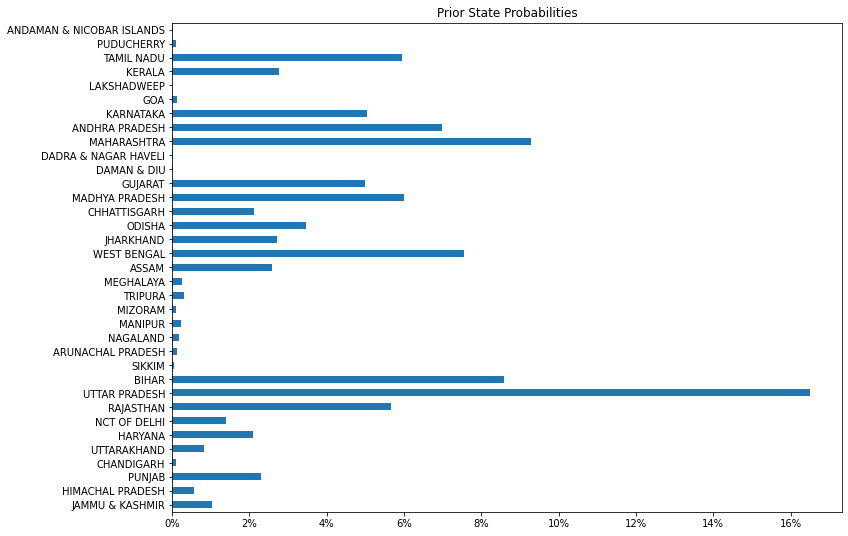

In [147]:
# Get state populations
state_priors = state_populations / total_population
state_priors = state_priors.rename('state_prior')

# Plot those populations
xticks = PercentFormatter(xmax=1, decimals=0)
ax = state_priors.plot.barh(figsize=(12,9),
                            title='Prior State Probabilities',
                            ylabel='',
                            xlabel='')
ax.xaxis.set_major_formatter(xticks)

And here we see a problem. A large chunk of people live in Uttar Pradesh. So, any model that we'd build would most likely classify people as being from UP, regardless of input data. However, if we find the right fields, we can make our model especially discerning. One way to find the right fields is to use the entropy of each field. Simply put, given any input, what is the likelihood we can predict the output.

## Computing Likelihoods for Given Input Fields

### Based on Age

Preliminary helper variables for both training and prediction

In [118]:
# Not sure if there's anyone in india older than 130
age_max = 130
age_min = 5

def parse_lower(age_range):
    delimiter = '+' if '+' in age_range else '-'
    txt = age_range.split(delimiter)[0]
    return int(txt)

def parse_upper(age_range):
    if '+' in age_range:
        return age_max 
    else:
        return int(age_range.split('-')[1])
    
def find_age_bucket(table, age):
    selector = (table['age_lower'] <= age) & (table['age_upper'] >= age)
    return table.loc[selector]

Get total age makeup in the country

In [71]:
age_evidence = get_dataset('PC11_B01',
                           state='0',
                           district='0',
                           scst='0',
                           urbrur='0',
                           sex='0',
                           work_status='0',
                           age='1-12',
                           fields='age,value')

age_evidence['age_lower'] = age_evidence['age'].map(parse_lower)
age_evidence['age_upper'] = age_evidence['age'].map(parse_upper)
del age_evidence['age']
age_evidence['value'] /= total_population
age_evidence

,value,age_lower,age_upper
0,0.104825,5,9
1,0.109600,10,14
2,0.099538,15,19
3,0.092021,20,24
4,0.083754,25,29
5,0.073167,30,34
6,0.070315,35,39
7,0.111290,40,49
8,0.072854,50,59
9,0.052953,60,69


Get likelihood of age for each state

In [83]:
age_likelihood_given_state = get_dataset('PC11_B01',
                                         state='1-35',
                                         district='0',
                                         scst='0',
                                         urbrur='0',
                                         sex='0',
                                         work_status='0',
                                         age='1-12',
                                         limit=420,
                                         fields='age,state,value')

age_likelihood_given_state['age_lower'] = age_likelihood_given_state['age'].map(parse_lower)
age_likelihood_given_state['age_upper'] = age_likelihood_given_state['age'].map(parse_upper)
del age_likelihood_given_state['age']
age_likelihood_given_state['value'] = age_likelihood_given_state.apply(lambda r: r['value'] / state_populations[r['state']], axis=1)
age_likelihood_given_state

,state,value,age_lower,age_upper
0,JAMMU & KASHMIR,0.112586,5,9
1,JAMMU & KASHMIR,0.112736,10,14
2,JAMMU & KASHMIR,0.098671,15,19
3,JAMMU & KASHMIR,0.092567,20,24
4,JAMMU & KASHMIR,0.086604,25,29
...,...,...,...,...
415,ANDAMAN & NICOBAR ISLANDS,0.132944,40,49
416,ANDAMAN & NICOBAR ISLANDS,0.081691,50,59
417,ANDAMAN & NICOBAR ISLANDS,0.043623,60,69
418,ANDAMAN & NICOBAR ISLANDS,0.016682,70,79


Get relative populations per sex in country. Unfortunately the only sexes are available are Male and Female. I can add an option for "Other" which will just ignore this term"

In [28]:
# Aptly named
sex_evidence = get_dataset('PC11_C01',
                           state='0',
                           sex='1,2',
                           urbrur='0',
                           geo_level='0',
                           religion='0',
                           fields='sex,value')
sex_evidence = sex_evidence.set_index('sex')['value']
sex_evidence = sex_evidence.rename('sex_evidence')
sex_evidence /= total_population
sex_evidence

sex
Male      0.514736
Female    0.485264
Name: sex_evidence, dtype: float64

Now do it for each state

In [29]:
sex_likelihood_given_state = get_dataset('PC11_C01',
                                         state='1-35',
                                         sex='1,2',
                                         urbrur='0',
                                         geo_level='1',
                                         religion='0',
                                         fields='state,sex,value')
sex_likelihood_given_state = sex_likelihood_given_state.set_index(['sex', 'state'])['value']
sex_likelihood_given_state /= state_populations
sex_likelihood_given_state

sex     state                    
Male    JAMMU & KASHMIR              0.529503
        HIMACHAL PRADESH             0.507221
        PUNJAB                       0.527675
        CHANDIGARH                   0.550157
        UTTARAKHAND                  0.509382
                                       ...   
Female  LAKSHADWEEP                  0.486250
        KERALA                       0.520224
        TAMIL NADU                   0.499107
        PUDUCHERRY                   0.509187
        ANDAMAN & NICOBAR ISLANDS    0.466944
Name: value, Length: 70, dtype: float64

### Based on Religion

Get total religious makeup in country as well as for each state

In [30]:
# Relative religions in the country
religion_evidence = get_dataset('PC11_C01',
                                state='0',
                                sex='0',
                                urbrur='0',
                                religion='1-6',
                                fields='religion,value')
religion_evidence = religion_evidence.set_index('religion')['value']
religion_evidence = religion_evidence.rename('religion_evidence')
religion_evidence /= total_population
religion_evidence

religion
Hindu        0.797996
Muslim       0.142251
Christian    0.022975
Sikh         0.017205
Buddhist     0.006973
Jain         0.003677
Name: religion_evidence, dtype: float64

In [31]:
# Likelihood of given religion per state
religion_likelihood_given_state = get_dataset('PC11_C01', 
                                              sex='0', 
                                              urbrur='0', 
                                              religion='1-6', 
                                              state='1-35', 
                                              district='0',
                                              fields='religion,state,value',
                                              limit=210)
religion_likelihood_given_state = religion_likelihood_given_state.set_index(['religion', 'state'])['value']
religion_likelihood_given_state /= state_populations
religion_likelihood_given_state

religion  state                    
Hindu     JAMMU & KASHMIR              0.284394
          HIMACHAL PRADESH             0.951660
          PUNJAB                       0.384890
          CHANDIGARH                   0.807782
          UTTARAKHAND                  0.829704
                                         ...   
Jain      LAKSHADWEEP                  0.000171
          KERALA                       0.000134
          TAMIL NADU                   0.001237
          PUDUCHERRY                   0.001122
          ANDAMAN & NICOBAR ISLANDS    0.000081
Name: value, Length: 210, dtype: float64

## Building and Testing Model

The naive bayesian model

In [132]:
def prediction_model(religion, age):
    # Religion odds calculations
    religion_odds = religion_likelihood_given_state[religion] 
    religion_odds /= religion_evidence[religion]
    
    # Age odds calculations
    age_likelihood_given_state_q = find_age_bucket(age_likelihood_given_state, age)
    age_likelihood_given_state_q = age_likelihood_given_state_q.set_index('state')['value']
    age_evidence_q = find_age_bucket(age_evidence, age)['value'].values[0]
    age_odds = age_likelihood_given_state_q / age_evidence_q
    
    # Return final state probabilities
    return state_priors * prod([
        religion_odds,
        age_odds
    ])

Here's an interactive tool used to predict what state you're from

In [148]:
n_results = 5

# Selection fields
religion_select = wg.Dropdown(options=['Hindu','Muslim','Christian','Sikh','Jain'],
                              value='Hindu',
                              description='Religion:',
                              disabled=False)
age_select = wg.BoundedIntText(min=age_min, 
                               max=age_max, 
                               value=10, 
                               description='Age:')
form = wg.VBox([ 
    age_select, 
    religion_select ])
graph_output = wg.Output()

def display_results(evt=None):
    """
    Display updated results of prediction
    any time a field changes
    """
    # Get posterior probabilities
    state_posterior = prediction_model(
        religion=religion_select.value,
        age=age_select.value)
    
    # Get top n values
    top_n = state_posterior.sort_values()[-n_results:]
    
    # Plot results on graph
    graph_output.clear_output()
    with graph_output:
        xticks = PercentFormatter(xmax=1, decimals=0)
        ax = top_n.plot.barh(xlabel='')
        ax.xaxis.set_major_formatter(xticks)
        plt.show();
        
# Hook callback to any change events
religion_select.observe(display_results, 'value')
age_select.observe(display_results, 'value')

# Display applet
display(wg.HBox([ form, graph_output ]))
display_results()